# What is the closest location within a specific distance that will get driver the highest tip based on time of the day and day of the week?

## Preamble

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd

## Load Data

In [2]:
df = pd.read_csv("datasets/yellow_tripdata_2013-01.csv")

## Preprocess data

In [3]:
# add day of week, pickup hour, tip percentage columns
timestamp = pd.to_datetime(pd.Series(df['pickup_datetime']))
df['day_of_week'] = timestamp.dt.weekday_name
df['pickup_hour'] = timestamp.dt.hour
df['tip_percentage'] = df.tip_amount / df.trip_distance
df.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,...,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,day_of_week,pickup_hour,tip_percentage
0,CMT,2013-01-01 15:11:48,2013-01-01 15:18:10,4,1.0,-73.978165,40.757977,1,N,-73.989840,...,CSH,6.5,0.0,0.5,0.0,0.0,7.0,Tuesday,15,0.0
1,CMT,2013-01-06 00:18:35,2013-01-06 00:22:54,1,1.5,-74.006680,40.731781,1,N,-73.994499,...,CSH,6.0,0.5,0.5,0.0,0.0,7.0,Sunday,0,0.0
2,CMT,2013-01-05 18:49:41,2013-01-05 18:54:23,1,1.1,-74.004711,40.737770,1,N,-74.009831,...,CSH,5.5,1.0,0.5,0.0,0.0,7.0,Saturday,18,0.0
3,CMT,2013-01-07 23:54:15,2013-01-07 23:58:20,2,0.7,-73.974600,40.759945,1,N,-73.984737,...,CSH,5.0,0.5,0.5,0.0,0.0,6.0,Monday,23,0.0
4,CMT,2013-01-07 23:25:03,2013-01-07 23:34:24,1,2.1,-73.976252,40.748528,1,N,-74.002583,...,CSH,9.5,0.5,0.5,0.0,0.0,10.5,Monday,23,0.0


In [4]:
# drop unnecessary columns
df = df.drop(['vendor_id','passenger_count','trip_distance','rate_code',
              'store_and_fwd_flag','payment_type','fare_amount','surcharge','mta_tax',
             'tip_amount','tolls_amount','total_amount','dropoff_datetime',
              'dropoff_longitude','dropoff_latitude'], axis=1)
df.head()

,pickup_datetime,pickup_longitude,pickup_latitude,day_of_week,pickup_hour,tip_percentage
0,2013-01-01 15:11:48,-73.978165,40.757977,Tuesday,15,0.0
1,2013-01-06 00:18:35,-74.006680,40.731781,Sunday,0,0.0
2,2013-01-05 18:49:41,-74.004711,40.737770,Saturday,18,0.0
3,2013-01-07 23:54:15,-73.974600,40.759945,Monday,23,0.0
4,2013-01-07 23:25:03,-73.976252,40.748528,Monday,23,0.0


In [5]:
def mileToDegree(mile):
    return float("{:.6f}".format(mile/60))

def getMaxLocation(location, mile):
    degree = mileToDegree(mile)
    max_locations = []
    max_locations.append({'longitude': location['longitude'] - degree,
                          'latitude': location['latitude'] - degree,})
    max_locations.append({'longitude': location['longitude'] + degree,
                          'latitude': location['latitude'] + degree,})
    return max_locations

inputs = {'mile': 1,
          'driver_location': {'longitude': -73.991340,'latitude': 40.744712}, # 38-98 West 26th Street, New York
          'hour': 16, # 4pm
          'day_of_week': 'Monday'}

max_location = getMaxLocation(inputs['driver_location'], inputs['mile'])
print(max_location)

df_selected = df[(df['pickup_latitude'] > max_location[0]['latitude']) & 
                 (df['pickup_longitude'] > max_location[0]['longitude']) &
                 (df['pickup_latitude'] < max_location[1]['latitude']) & 
                 (df['pickup_longitude'] < max_location[1]['longitude']) &
                 (df['pickup_hour'] == inputs['hour']) & 
                 (df['day_of_week'] == inputs['day_of_week']) &
                 (np.isfinite(df['tip_percentage']))]

df_selected.head()

[{'latitude': 40.728045, 'longitude': -74.00800699999999}, {'latitude': 40.761379, 'longitude': -73.974673}]


,pickup_datetime,pickup_longitude,pickup_latitude,day_of_week,pickup_hour,tip_percentage
1401,2013-01-07 16:31:19,-73.990359,40.749484,Monday,16,0.000000
1409,2013-01-07 16:33:18,-73.978652,40.752362,Monday,16,0.000000
236679,2013-01-14 16:03:00,-73.998682,40.734862,Monday,16,0.000000
236682,2013-01-14 16:00:00,-73.983912,40.760037,Monday,16,0.000000
236687,2013-01-14 16:00:00,-73.978950,40.753150,Monday,16,0.574713


In [6]:
import matplotlib.path as mplPath

def indexZones(shapeFilename):
    import rtree
    import fiona.crs
    import geopandas as gpd
    index = rtree.Rtree()
    zones = gpd.read_file(shapeFilename).to_crs(fiona.crs.from_epsg(2263))
    for idx,geometry in enumerate(zones.geometry):
        index.insert(idx, geometry.bounds)
    return (index, zones)

def findBlock(p, index, zones):
    match = index.intersection((p.x, p.y, p.x, p.y))
    for idx in match:
        z = mplPath.Path(np.array(zones.geometry[idx].exterior))
        if z.contains_point(np.array(p)):
            return zones['OBJECTID'][idx]
    return -1


def mapToZone(location):
    import pyproj
    import shapely.geometry as geom
    proj = pyproj.Proj(init="epsg:2263", preserve_units=True)    
    index, zones = indexZones('datasets/block-groups-polygons.geojson')
    if (location['pickup_longitude'] and location['pickup_latitude']):
        pickup_location  = geom.Point(proj(float(location['pickup_longitude']), float(location['pickup_latitude'])))
        pickup_block = findBlock(pickup_location, index, zones)
        return pickup_block
    else: 
        return -1

# df['block_id'] = df.apply(lambda row: mapToZone(row), axis=1)
# df.head()

In [7]:
from sklearn.cluster import KMeans

num_clusters = 200
tips = df_selected['tip_percentage'].values
lon = df_selected['pickup_longitude'].values
lat = df_selected['pickup_latitude'].values

coodinate_array = np.array([[lon[i],lat[i],tips[i]] for i in range(len(lon))])

kmeans_n = KMeans(n_clusters=num_clusters, n_init=1)
kmeans_n.fit(coodinate_array)
labels = kmeans_n.labels_
print(labels)

[189 182 172 ...,  97 187 133]


In [8]:
df_selected['Cluster'] = labels
df_selected.head(10)

/Users/Linfinity/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,pickup_datetime,pickup_longitude,pickup_latitude,day_of_week,pickup_hour,tip_percentage,Cluster
1401,2013-01-07 16:31:19,-73.990359,40.749484,Monday,16,0.000000,189
1409,2013-01-07 16:33:18,-73.978652,40.752362,Monday,16,0.000000,182
236679,2013-01-14 16:03:00,-73.998682,40.734862,Monday,16,0.000000,172
236682,2013-01-14 16:00:00,-73.983912,40.760037,Monday,16,0.000000,133
236687,2013-01-14 16:00:00,-73.978950,40.753150,Monday,16,0.574713,143
236691,2013-01-14 16:06:00,-73.992438,40.734263,Monday,16,5.172414,138
237227,2013-01-14 16:04:00,-73.980545,40.742392,Monday,16,2.083333,147
237229,2013-01-14 16:02:00,-74.007587,40.745142,Monday,16,1.282051,151
237254,2013-01-14 16:02:00,-73.990333,40.737305,Monday,16,1.339286,37
237256,2013-01-14 16:02:00,-73.987955,40.745918,Monday,16,0.000000,55


In [9]:
#prepare for regression
df_selected_cluster = df_selected.groupby('Cluster')
cluster_tip = df_selected_cluster.tip_percentage.sum() / df_selected_cluster.size()
cluster_tip = np.array([[cluster_tip[i]] for i in range(len(cluster_tip))])
cluster_center = kmeans_n.cluster_centers_

## Training Data and Testing Data

In [10]:
train_size = int(len(cluster_tip)*0.8)
test_size = int(len(cluster_tip)*0.2)
train_feature = cluster_tip[:train_size]
train_response = cluster_center[:train_size]
test_feature = cluster_tip[test_size:]
test_response = cluster_center[test_size:]

## Validation

In [23]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline


def fit_model(X, y):
    model = Pipeline([('poly', PolynomialFeatures(degree=4)),
                      ('linear', LinearRegression(fit_intercept=False))])
    model.fit(X, y)
    return model

def score_model(model, X, y, Xv, yv):
    return tuple([model.score(X, y), model.score(Xv, yv)])

def fit_model_and_score(data, response, validation, val_response):
    model = fit_model(data, response)
    return score_model(model, data, response, validation, val_response)

print (fit_model_and_score(train_feature, train_response, test_feature, test_response))

(0.99999999396841854, 0.99999930008260707)


## MSE

In [24]:
# use mean squared error to evaluation model
from sklearn.metrics import mean_squared_error

MSE_model = Pipeline([('poly', PolynomialFeatures(degree=4)),
                      ('linear', LinearRegression(fit_intercept=False))])
MSE_model.fit(train_feature, train_response)
x_MSE = test_feature
y_MSE = MSE_model.predict(x_MSE)
mean_squared_error(test_response, y_MSE)

1.6480707178628338e-05

## Prediction

In [25]:
model = Pipeline([('poly', PolynomialFeatures(degree=4)),
                  ('linear', LinearRegression(fit_intercept=False))])
model.fit(cluster_tip, cluster_center) # x: cluster_tip, y: cluster_center
x_predict = (max(cluster_tip))
y_predict = model.predict(x_predict)
y_predict

/Users/Linfinity/anaconda/envs/py3k/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([[  -73.98457199,    40.73222499,  1039.99985621]])

In [26]:
from pygeocoder import Geocoder
predicted_location = Geocoder.reverse_geocode(y_predict[0][1], y_predict[0][0])
# predicted_location.street_address might not be applicable
if predicted_location.street_address:
    predicted_address = predicted_location.street_address
else:
    predicted_address = '%s %s, %s' %(predicted_location.street_number, predicted_location.route, predicted_location.city)
print (predicted_address)

301 East 14th Street, New York


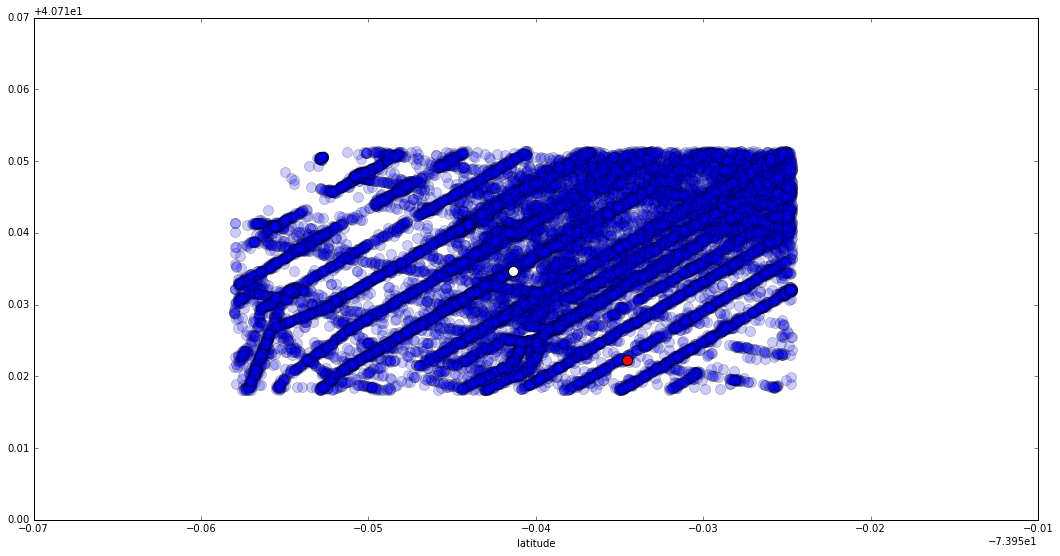

In [45]:
result_x = y_predict[0][0]
result_y = y_predict[0][1]
plt.figure(figsize=(18,9))
plt.scatter(lon,lat,alpha=0.2,s=100)
plt.scatter(result_x,result_y,c='r',s=100)
plt.scatter(inputs['driver_location']['longitude'],inputs['driver_location']['latitude'],c='w',s=100)
plt.xlabel('longitude')
plt.xlabel('latitude')
plt.show()